In [1]:
import os
# tensorflow import must come after os.environ gpu setting
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import sys
import numpy as np
np.random.seed(0)


In [2]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.python.ops import math_ops
# Custom loss layer
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)

    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(1.), trainable=True)]
        super().build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for i, (y_true, y_pred, log_var) in enumerate(zip(ys_true, ys_pred, self.log_vars)):
            if i == 0:
                loss += K.sum((y_true - y_pred)**2.)
                # tf.print('regression', loss, log_var[0])
            else:
                loss += K.sum(tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.5, from_logits=False)) # + tf.math.log(log_var[0])
                # loss += precision * K.sum(tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.5, from_logits=False)) + log_var[0]
                # tf.print('classificaiton', loss, log_var[0])
        return loss

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return loss

# Evaluate on synthetic data

In [3]:
N = 500
nb_epoch = 100
batch_size = 64
nb_features = 1024
Q = 1
D1 = 1  # first output
D2 = 1  # second output

In [4]:
def gen_data(N):
    X = np.random.randn(N, Q)
    X_test = np.random.randn(N, Q)

    w1 = 8
    b1 = 2
    sigma1 = 1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    Y1_test = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)

    # normalize
    # Y1 = Y1 + np.absolute(np.amin(Y1))
    # Y1 = Y1/np.amax(Y1)

    # w2 = 3
    # b2 = 3.
    # sigma2 = 1e0  # ground truth
    # Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    Y2 = np.random.randn(N, D2) > 0
    Y2_test = np.random.randn(N, D2) > 0
    return X, Y1, Y2, X_test, Y1_test, Y2_test

243 257


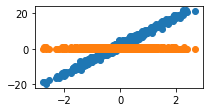

In [5]:
import pylab
%matplotlib inline

X, Y1, Y2, X_test, Y1_test, Y2_test = gen_data(N)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
print(np.sum(Y2>0), np.sum(Y2==0))
pylab.show()

In [6]:
def get_prediction_model():
    inp = Input(shape=(Q,), name='inp')
    x = Dense(nb_features, activation='relu')(inp)
    x = Dense(nb_features, activation='relu')(x)

    y1_pred = Dense(D1, name='regressor')(x)
    y2_pred = Dense(D2, activation='sigmoid', name='classifier')(x)

    return Model(inp, [y1_pred, y2_pred])

def get_trainable_model(prediction_model):
    inp = Input(shape=(Q,), name='inp')
    y1_pred, y2_pred = prediction_model(inp)
    y1_true = Input(shape=(D1,), name='y1_true')
    y2_true = Input(shape=(D2,), name='y2_true')
    out = CustomMultiLossLayer(nb_outputs=2)([y1_true, y2_true, y1_pred, y2_pred])
    return Model([inp, y1_true, y2_true], out)

prediction_model = get_prediction_model()

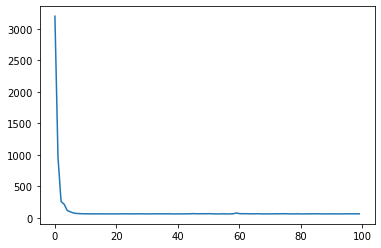

In [7]:
trainable_model = get_trainable_model(prediction_model)

trainable_model.compile(optimizer='adam', loss=None)
assert len(trainable_model.losses) == 1
hist = trainable_model.fit([X, Y1, Y2], epochs=nb_epoch, batch_size=batch_size, verbose=0)

pylab.plot(hist.history['loss'])

In [8]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# new_prediction_model = get_prediction_model()
# pred_output = new_prediction_model.predict(X)
pred_output = prediction_model.predict(X_test)

print(tf.__version__)
print(pred_output[0].shape)
print(pred_output[1].shape)

m = tf.keras.metrics.MeanSquaredError()
m.update_state(Y1_test, pred_output[0])
tf.print('regression:',m.result())

threshold=0.5
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(Y2_test, pred_output[1]>threshold)
tf.print('Classification:', m.result())
tn, fp, fn, tp = confusion_matrix(Y2_test, pred_output[1]>threshold).ravel()
mcc = matthews_corrcoef(Y2_test, pred_output[1]>threshold)
print(tn, fp, fn, tp, mcc, '\n')

# print(Y1_test[:10,0])
# print(pred_output[0][:10,0])
# print(Y2_test[:50,0])
# print(pred_output[1][:50,0])


2.4.0
(500, 1)
(500, 1)
regression: 129.215607
Classification: 0.52
120 147 93 140 0.05073892035370996 



In [9]:
# Found standard deviations (ground truth is 10 and 1):
[np.exp(K.get_value(log_var[0]))**0.5 for log_var in trainable_model.layers[-1].log_vars]


[1.64872124566606, 1.64872124566606]